# Predicción de despacho de productos
## Alternativa 1: Modelo por cada producto

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm


In [2]:
# conn = sqlite3.connect('../data/data.db')
# df_sellin = pd.read_sql_query("SELECT * FROM sellin WHERE product_id in (select product_id from product_id_kaggle);", conn)
df_sellin = pd.read_csv('../data/sell-in.txt', sep='\t')
df_sellin.head()

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201701,10234,20524,0,2,0.05300,0.05300
1,201701,10032,20524,0,1,0.13628,0.13628
2,201701,10217,20524,0,1,0.03028,0.03028
3,201701,10125,20524,0,1,0.02271,0.02271
4,201701,10012,20524,0,11,1.54452,1.54452


In [4]:
df_tn_por_producto_periodo = df_sellin.groupby(['periodo', 'product_id'])['tn'].sum().reset_index()
df_tn_por_producto_periodo.head()

,periodo,product_id,tn
0,201701,20001,934.77222
1,201701,20002,550.15707
2,201701,20003,1063.45835
3,201701,20004,555.91614
4,201701,20005,494.27011


In [5]:
df_tn_por_producto_periodo.shape

(31243, 3)

In [6]:
# Cargar el archivo de texto con un valor por fila
product_ids_apredecir = pd.read_csv('../data/product_id_apredecir201912.txt', names=['product_id'])

In [9]:
# Asegurarse de que los tipos coincidan para la comparación
# Elimina la primera fila si contiene el nombre de la columna como valor
product_ids_list = product_ids_apredecir[product_ids_apredecir['product_id'] != 'product_id']['product_id'].astype(int).tolist()
df_filtrado = df_tn_por_producto_periodo[df_tn_por_producto_periodo['product_id'].isin(product_ids_list)]
df_filtrado.head()

,periodo,product_id,tn
0,201701,20001,934.77222
1,201701,20002,550.15707
2,201701,20003,1063.45835
3,201701,20004,555.91614
4,201701,20005,494.27011


In [10]:
df_filtrado.shape

(22349, 3)

In [11]:
df_tn_por_producto_periodo = df_filtrado.copy()

In [12]:
num_distinct_products = df_tn_por_producto_periodo['product_id'].nunique()
print(f"Number of distinct products: {num_distinct_products}")

Number of distinct products: 780


In [13]:
df = df_tn_por_producto_periodo.copy()

In [14]:
df.head()

,periodo,product_id,tn
0,201701,20001,934.77222
1,201701,20002,550.15707
2,201701,20003,1063.45835
3,201701,20004,555.91614
4,201701,20005,494.27011


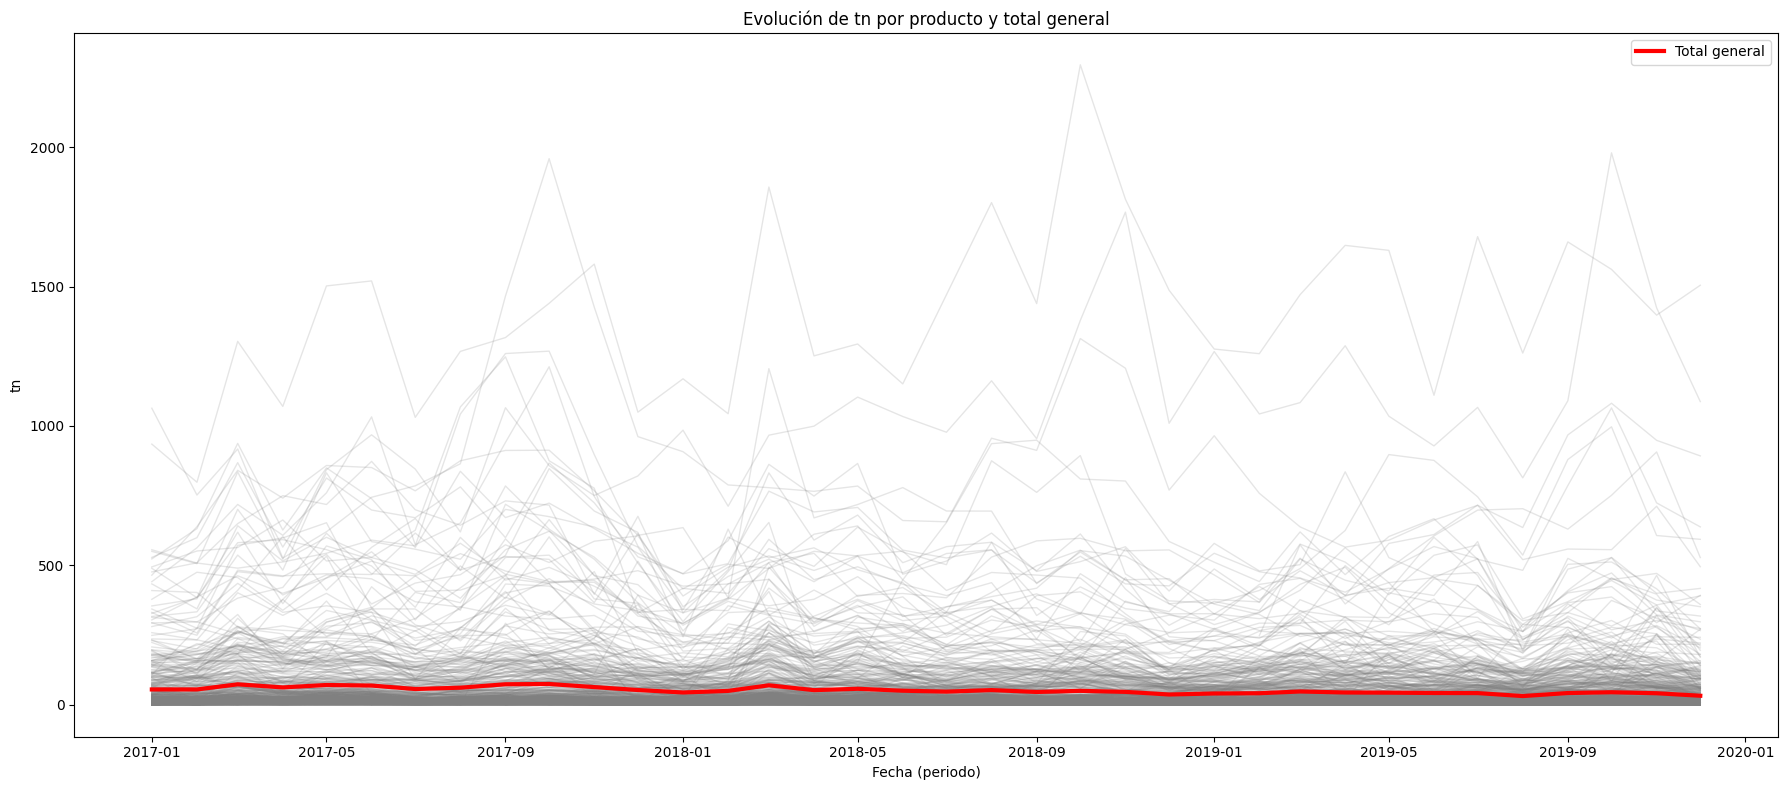

In [15]:

# Convertir 'periodo' a string y luego a datetime para mejor manejo en el eje x
df['periodo_dt'] = pd.to_datetime(df['periodo'].astype(str), format='%Y%m')

plt.figure(figsize=(18, 8))

# Graficar una línea por producto
for product_id, group in df.groupby('product_id'):
    plt.plot(group['periodo_dt'], group['tn'], color='gray', alpha=0.2, linewidth=1)

# Línea del comportamiento general (suma total de tn por periodo)
df_total = df.groupby('periodo_dt')['tn'].mean().reset_index()
plt.plot(df_total['periodo_dt'], df_total['tn'], color='red', linewidth=3, label='Total general')

plt.xlabel('Fecha (periodo)')
plt.ylabel('tn')
plt.title('Evolución de tn por producto y total general')
plt.legend()
plt.tight_layout()
plt.show()

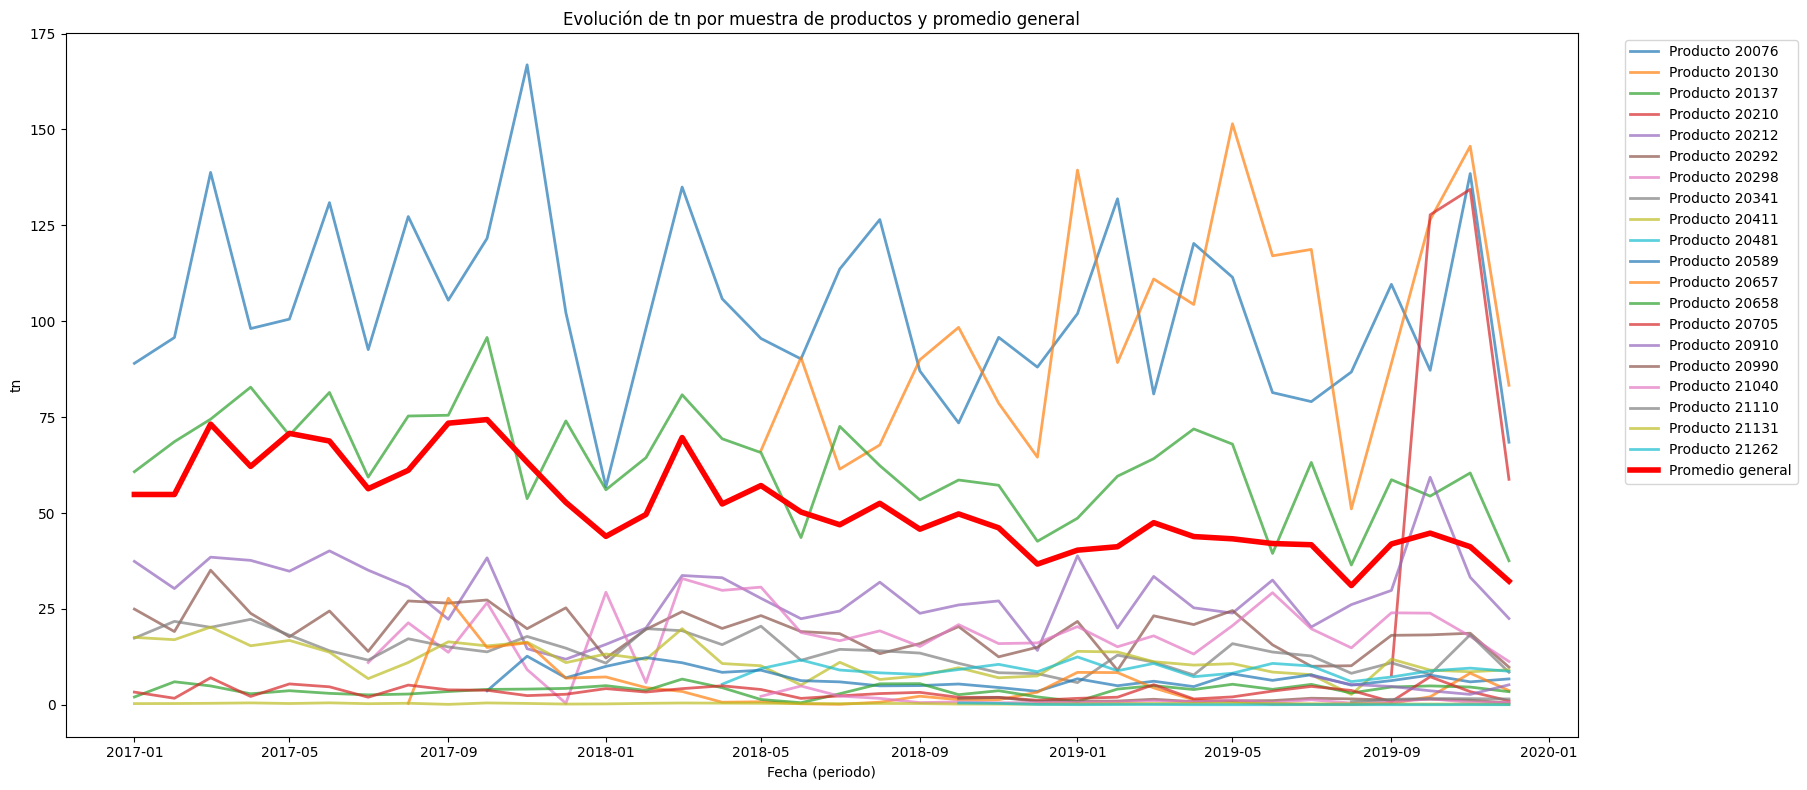

In [16]:


plt.figure(figsize=(18, 8))

# Selecciona una muestra aleatoria de 20 productos
np.random.seed(42)
sample_products = np.random.choice(df['product_id'].unique(), size=20, replace=False)

for product_id, group in df[df['product_id'].isin(sample_products)].groupby('product_id'):
    plt.plot(group['periodo_dt'], group['tn'], alpha=0.7, linewidth=2, label=f'Producto {product_id}')

# Línea del comportamiento general (media)
df_total = df.groupby('periodo_dt')['tn'].mean().reset_index()
plt.plot(df_total['periodo_dt'], df_total['tn'], color='red', linewidth=4, label='Promedio general')

plt.xlabel('Fecha (periodo)')
plt.ylabel('tn')
plt.title('Evolución de tn por muestra de productos y promedio general')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()


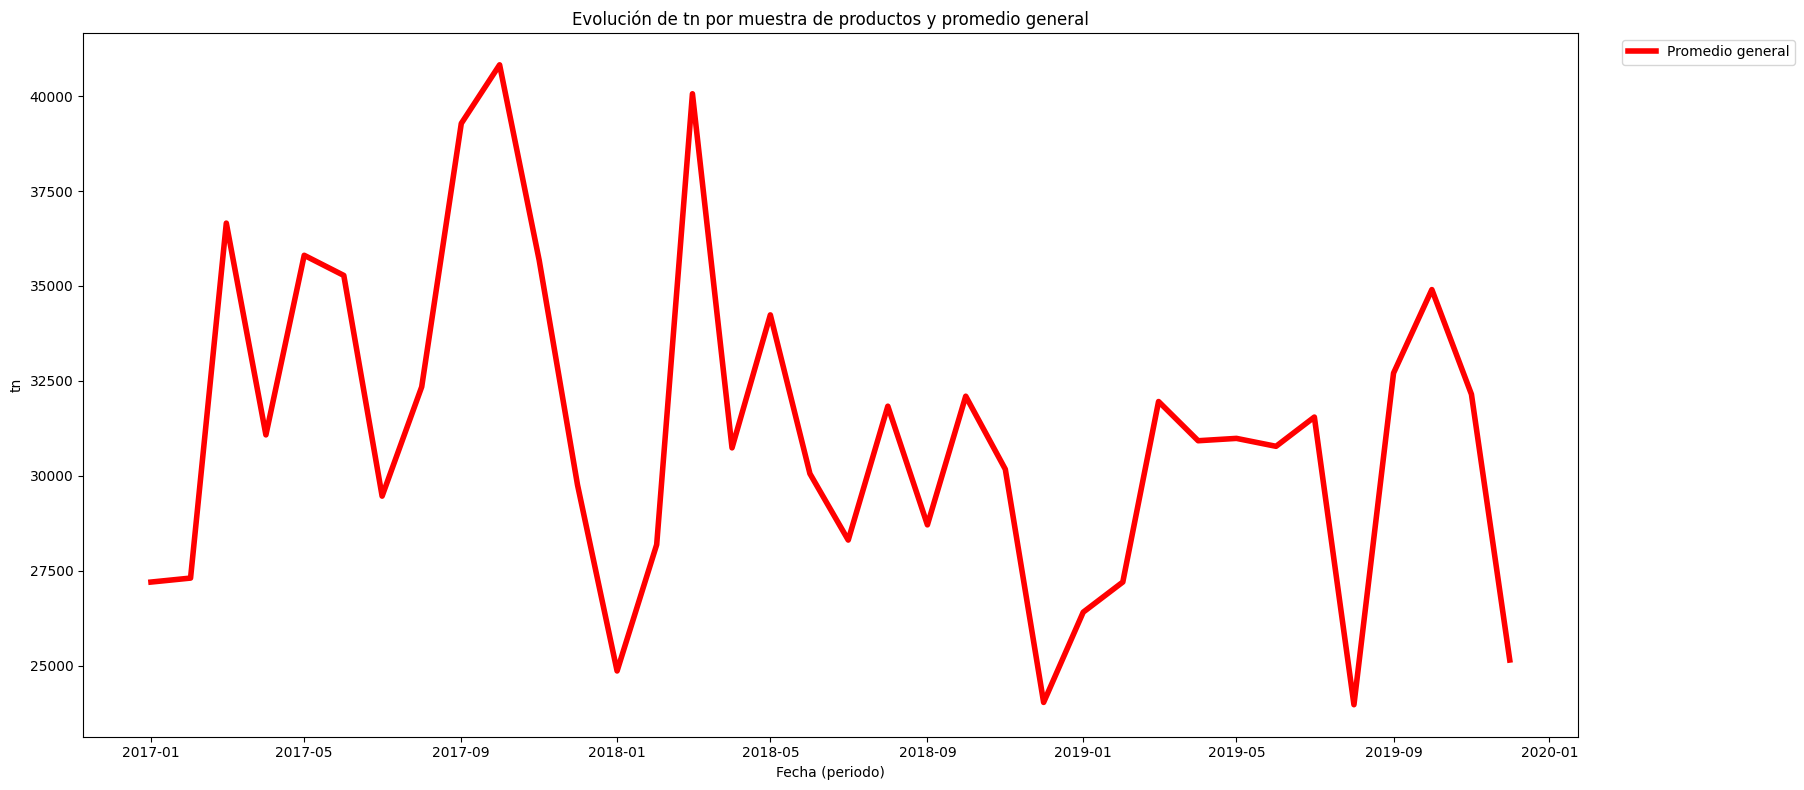

In [17]:


plt.figure(figsize=(18, 8))

# Selecciona una muestra aleatoria de 20 productos
np.random.seed(42)
sample_products = np.random.choice(df['product_id'].unique(), size=20, replace=False)

# Línea del comportamiento general (media)
df_total = df.groupby('periodo_dt')['tn'].sum().reset_index()
plt.plot(df_total['periodo_dt'], df_total['tn'], color='red', linewidth=4, label='Promedio general')

plt.xlabel('Fecha (periodo)')
plt.ylabel('tn')
plt.title('Evolución de tn por muestra de productos y promedio general')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()


In [18]:

pivot_df = df.pivot_table(
    index=['product_id'],
    columns='periodo',
    values='tn'
).reset_index()

pivot_df.columns.name = None
pivot_df = pivot_df.rename_axis(None, axis=1)

pivot_df.head()

,product_id,201701,201702,201703,201704,201705,201706,201707,201708,201709,...,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912
0,20001,934.77222,798.01620,1303.35771,1069.96130,1502.20132,1520.06539,1030.67391,1267.39462,1316.94604,...,1470.65653,1647.63848,1629.78233,1109.93769,1678.99318,1261.34529,1660.00561,1561.50552,1397.37231,1504.68856
1,20002,550.15707,505.88633,834.73521,522.35365,843.43785,968.15756,845.39319,619.71078,1065.34529,...,1083.62552,1287.62346,1034.98927,928.36431,1066.44999,813.78215,1090.18771,1979.53635,1423.57739,1087.30855
2,20003,1063.45835,752.11520,917.16548,525.82591,620.48202,744.08829,785.12398,864.21928,1465.83347,...,638.04010,565.33774,590.12515,662.38654,715.20314,635.59563,967.77116,1081.36645,948.29393,892.50129
3,20004,555.91614,508.20044,489.91328,512.05402,543.36670,590.50779,569.88117,1042.52979,1259.64560,...,619.77084,466.70901,603.31081,667.19411,521.71519,482.13372,786.17140,1064.69633,723.94206,637.90002
4,20005,494.27011,551.43060,563.89955,662.59032,515.58711,528.58883,625.84925,1068.01865,1247.88880,...,488.21387,624.99880,897.26297,876.39696,745.74978,536.66800,879.52808,996.78275,606.91173,593.24443


In [19]:
pivot_df.shape

(780, 37)

In [ ]:
i = 20001
serie = pivot_df[pivot_df['product_id'] == i].iloc[0, 1:]  # Exclude 'product_id' column
serie = serie.dropna()

# Convert index to datetime for SARIMAX
# Assuming your index is in 'YYYYMM' format
serie.index = pd.to_datetime(serie.index.astype(str), format='%Y%m')
serie = serie.sort_index()

# Define training and testing periods
train_end_date = '2019-10-31'
test_date = '2019-12-01' # For prediction

# Split data
train_data = serie[serie.index <= train_end_date]
test_data = serie[serie.index == test_date]

# Define SARIMAX model parameters
# These are example parameters; you'll likely need to tune them
# (p, d, q) are for the non-seasonal part
# (P, D, Q, S) are for the seasonal part, where S is the periodicity (e.g., 12 for monthly data)
# En el hemisferio sur, las estaciones duran 3 meses: verano (dic-ene-feb), otoño (mar-abr-may), invierno (jun-jul-ago), primavera (sep-oct-nov)
# Por lo tanto, la periodicidad estacional S es 12/4 = 3 meses por estación, pero para SARIMAX se usa S=4 para ciclos de 4 estaciones al año
order = (1, 1, 1)
seasonal_order = (1, 1, 0, 4)  # S=4 para capturar la estacionalidad de las estaciones (trimestres)

# Initialize and fit the SARIMAX model
# 'enforce_stationarity=False' and 'enforce_invertibility=False' can help with convergence
model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False) # disp=False to suppress optimization output

# Make prediction for December 2019
start_index = pd.to_datetime(test_date)
end_index = pd.to_datetime(test_date)

# Predict using the fitted model
pred_201912 = model_fit.predict(start=start_index, end=end_index)

print(f"Predicción para product_id={i} en 2019-12: {pred_201912.iloc[0]:.5f}")

if not test_data.empty:
    print(f"Valor real: {test_data.iloc[0]:.5f}")
    # Optional: Calculate and print RMSE for evaluation
    # rmse = np.sqrt(mean_squared_error(test_data, pred_201912))
    # print(f"RMSE: {rmse:.5f}")
else:
    print("No hay valor real disponible para comparación.")

Predicción para product_id=20001 en 2019-12: 1482.58617
Valor real: 1504.68856


/media/nespina/Elements/maestriacd/austral/labo_3/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/media/nespina/Elements/maestriacd/austral/labo_3/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [21]:
sarimax_preds = []
sarimax_real = []
product_ids = []

for prod_id in pivot_df['product_id']:
    serie = pivot_df[pivot_df['product_id'] == prod_id].iloc[0, 1:]
    serie = serie.dropna()
    if len(serie) < 8 or 201912 not in serie.index:
        continue  # Necesitamos suficientes datos y valor real en 201912

    # Convertir el índice a fechas para SARIMAX
    serie.index = pd.to_datetime(serie.index.astype(str), format='%Y%m')

    # Entrenar hasta octubre 2019
    train_data = serie[serie.index <= '2019-10-31']
    test_data = serie[serie.index == '2019-12-01']

    try:
        model = SARIMAX(train_data, order=(1,1,1), seasonal_order=(1,1,0,4),
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        pred = model_fit.predict(start=pd.to_datetime('2019-12-01'), end=pd.to_datetime('2019-12-01'))
        sarimax_preds.append(pred.iloc[0])
        sarimax_real.append(test_data.iloc[0])
        product_ids.append(prod_id)
    except Exception:
        continue

df_sarimax_pred = pd.DataFrame({
    'product_id': product_ids,
    'sarimax_pred_201912': sarimax_preds,
    'real_201912': sarimax_real
})

df_sarimax_pred.head()


/media/nespina/Elements/maestriacd/austral/labo_3/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/media/nespina/Elements/maestriacd/austral/labo_3/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/media/nespina/Elements/maestriacd/austral/labo_3/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/media/nespina/Elements/maestriacd/austral/labo_3/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/media/n

,product_id,sarimax_pred_201912,real_201912
0,20001,1482.586171,1504.68856
1,20002,1296.222812,1087.30855
2,20003,948.836145,892.50129
3,20004,1097.327097,637.90002
4,20005,1007.079096,593.24443


In [22]:
# Calcula el error porcentual absoluto medio (MAPE) entre las predicciones SARIMAX y los valores reales
mape_sarimax = np.mean(np.abs((df_sarimax_pred['real_201912'] - df_sarimax_pred['sarimax_pred_201912']) / df_sarimax_pred['real_201912'])) * 100
print(f"Error porcentual absoluto medio (MAPE) SARIMAX: {mape_sarimax:.2f}%")

Error porcentual absoluto medio (MAPE) SARIMAX: 142.01%


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


# Selecciona el producto i (por ejemplo, product_id = 20001)
i = 20003
serie = pivot_df[pivot_df['product_id'] == i].iloc[0, 1:]  # Excluye la columna product_id
serie = serie.dropna()

# Prepara los datos: X = mes (como entero), y = tn
X = np.array(serie.index.astype(int)).reshape(-1, 1)
y = serie.values

# Train: hasta octubre 2019 (201910)
train_mask = X.flatten() <= 201910
X_train, y_train = X[train_mask], y[train_mask]

# Test: diciembre 2019 (201912)
test_mask = X.flatten() == 201912
X_test, y_test = X[test_mask], y[test_mask]

# Modelo simple: regresión lineal sobre el tiempo
# model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
# model = RandomForestRegressor(random_state=42)
model = RandomForestRegressor(random_state=42, n_estimators=250, max_depth=5, min_samples_split=8, min_samples_leaf=1, max_features='sqrt', bootstrap=True)
model = RandomForestRegressor(random_state=42, n_estimators=250, max_depth=5, min_samples_split=8, min_samples_leaf=1, max_features='sqrt', bootstrap=True)

# model = LinearRegression()

model.fit(X_train, y_train)

# Predicción para diciembre 2019 (201912)
pred_201912 = model.predict(np.array([[201912]]))[0]

print(f"Predicción para product_id={i} en 2019-12: {pred_201912:.5f}")
if len(y_test) > 0:
    print(f"Valor real: {y_test[0]:.5f}")
else:
    print("No hay valor real disponible para comparación.")

In [ ]:
from skopt.space import Integer, Categorical
from skopt import BayesSearchCV
iter = 0

# Definir el espacio de búsqueda de hiperparámetros
param_space = {
    'n_estimators': Categorical([50, 100, 150, 200, 250, 300]),#Integer(50, 400),
    'max_depth': Categorical([1, 5, 10, 20]),
    'min_samples_split':  Categorical([2, 4, 6, 8, 10]),
    'min_samples_leaf':  Categorical([1, 3, 5, 7]),
    'max_features': Categorical(['sqrt', 'log2']),
    'bootstrap': Categorical([True])
}


# Optimización bayesiana con logging
opt = BayesSearchCV(
    RandomForestRegressor(random_state=42),
    param_space,
    n_iter=100,
    cv=3,
    n_jobs=1,
    random_state=42,
    scoring='neg_mean_squared_error',
    verbose=1
)

opt.fit(X_train, y_train)
model = opt.best_estimator_

# Predicción para diciembre 2019 (201912)
pred_201912 = model.predict(np.array([[201912]]))[0]

print(f"Predicción para product_id={i} en 2019-12: {pred_201912:.5f}")
if len(y_test) > 0:
    print(f"Valor real: {y_test[0]:.5f}")
else:
    print("No hay valor real disponible para comparación.")

In [ ]:
# Creamos un diccionario para almacenar las predicciones
predicciones = {}

for prod_id in pivot_df['product_id']:
    serie = pivot_df[pivot_df['product_id'] == prod_id].iloc[0, 1:]  # Excluye la columna product_id
    serie = serie.dropna()
    if len(serie) < 2:
        continue  # No se puede ajustar un modelo con menos de 2 puntos

    X_prod = np.array(serie.index.astype(int)).reshape(-1, 1)
    y_prod = serie.values

    # Train: hasta octubre 2019 (201910)
    train_mask = X_prod.flatten() <= 201910
    X_train_prod, y_train_prod = X_prod[train_mask], y_prod[train_mask]

    # Modelo simple: regresión lineal sobre el tiempo
    if len(X_train_prod) < 2:
        continue  # No se puede ajustar un modelo con menos de 2 puntos

    # model_prod = LinearRegression()
    model_prod = RandomForestRegressor(random_state=42, n_estimators=250, max_depth=5, min_samples_split=8, min_samples_leaf=1, max_features='sqrt', bootstrap=True)
    model_prod.fit(X_train_prod, y_train_prod)

    # Predicción para diciembre 2019 (201912)
    pred_201912 = model_prod.predict(np.array([[201912]]))[0]
    predicciones[prod_id] = pred_201912

# Convertimos el diccionario a DataFrame para visualizar
df_predicciones = pd.DataFrame(list(predicciones.items()), columns=['product_id', 'pred_201912'])
df_predicciones.head()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcula el accuracy de las predicciones usando el error absoluto medio (MAE) y el error cuadrático medio (RMSE)
# Solo para productos que tienen valor real en 201912

# Extraer los valores reales de 201912 para cada producto
valores_reales = df[df['periodo'] == 201912][['product_id', 'tn']]

# Unir con las predicciones
df_eval = pd.merge(df_predicciones, valores_reales, on='product_id', how='inner')

# Calcular métricas

mae = mean_absolute_error(df_eval['tn'], df_eval['pred_201912'])
rmse = mean_squared_error(df_eval['tn'], df_eval['pred_201912'], squared=False)

print(f"MAE (Error absoluto medio): {mae:.4f}")
print(f"RMSE (Raíz del error cuadrático medio): {rmse:.4f}")

In [ ]:
df_eval.head(20)

In [ ]:
mape = np.mean(np.abs((df_eval['tn'] - df_eval['pred_201912']) / df_eval['tn'])) * 100
print(f"MAPE (Error porcentual absoluto medio): {mape:.2f}%")

In [ ]:
# Desvío promedio porcentual de las predicciones respecto a los valores reales
desvio_promedio = np.mean(np.abs(df_eval['pred_201912'] - df_eval['tn']) / df_eval['tn']) * 100
print(f"Desvío promedio porcentual: {desvio_promedio:.2f}%")

In [ ]:


# Selecciona la serie temporal del producto 20001
serie_20001 = pivot_df[pivot_df['product_id'] == 20001].iloc[0, 1:]  # Excluye la columna product_id
serie_20001 = serie_20001.dropna()

# Convierte el índice a periodo de fecha para la serie temporal
serie_20001.index = pd.to_datetime(serie_20001.index.astype(str), format='%Y%m')

# Ajusta el modelo SARIMAX considerando estacionalidad trimestral (4 meses por estación)
model_sarimax = SARIMAX(serie_20001, order=(1,1,1), seasonal_order=(1,1,1,4))
result_sarimax = model_sarimax.fit(disp=False)

# Predicción para diciembre 2019
pred_sarimax = result_sarimax.get_prediction(start=pd.to_datetime('2019-12-01'), end=pd.to_datetime('2019-12-01'))
pred_value = pred_sarimax.predicted_mean.iloc[0]

print(f"Predicción SARIMAX para product_id=20001 en 2019-12: {pred_value:.5f}")

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_preds = []
sarimax_real = []

for prod_id in pivot_df['product_id']:
    serie = pivot_df[pivot_df['product_id'] == prod_id].iloc[0, 1:]
    serie = serie.dropna()
    if len(serie) < 8 or 201912 not in serie.index:
        continue  # Necesitamos suficientes datos y valor real en 201912

    # Convertir el índice a fechas para SARIMAX
    serie.index = pd.to_datetime(serie.index.astype(str), format='%Y%m')

    # SARIMAX simple, estacionalidad trimestral (4)
    try:
        model = SARIMAX(serie.iloc[:-1], order=(1,1,1), seasonal_order=(1,1,1,4))
        result = model.fit(disp=False)
        pred = result.get_prediction(start=serie.index[-1], end=serie.index[-1])
        pred_value = pred.predicted_mean.iloc[0]
        real_value = serie.iloc[-1]
        sarimax_preds.append(pred_value)
        sarimax_real.append(real_value)
    except Exception as e:
        continue  # Si falla el ajuste, lo salteamos

sarimax_preds = np.array(sarimax_preds)
sarimax_real = np.array(sarimax_real)
sarimax_mape = np.mean(np.abs((sarimax_real - sarimax_preds) / sarimax_real)) * 100
print(f"MAPE SARIMAX (Error porcentual absoluto medio): {sarimax_mape:.2f}%")

In [ ]:
# Suma total de toneladas reales para diciembre 2019
total_real_dic2019 = valores_reales['tn'].sum()

# Suma total de toneladas predichas para diciembre 2019 (usar df_predicciones)
total_pred_dic2019 = df_predicciones['pred_201912'].sum()

print(f"Suma total real de toneladas en diciembre 2019: {total_real_dic2019:.2f}")
print(f"Suma total predicha de toneladas en diciembre 2019: {total_pred_dic2019:.2f}")

In [ ]:
# Predicción Seasonal Naive Forecast para diciembre 2019 (2019-12-01)
# Usamos el valor de diciembre 2018 (2018-12-01) como predicción para diciembre 2019

# Proyección lineal simple usando solo los valores de 2017-12-01 y 2018-12-01 para cada producto
linear_simple_preds = []
linear_simple_real = []

for prod_id in pivot_df['product_id']:
    serie = pivot_df[pivot_df['product_id'] == prod_id].iloc[0, 1:]
    serie = serie.dropna()
    # Convertir el índice a fechas
    serie.index = pd.to_datetime(serie.index.astype(str), format='%Y%m')
    # Necesitamos valores para 2017-12-01, 2018-12-01 y 2019-12-01
    if (
        pd.Timestamp('2017-12-01') in serie.index and
        pd.Timestamp('2018-12-01') in serie.index and
        pd.Timestamp('2019-12-01') in serie.index
    ):
        x = np.array([201712, 201812]).reshape(-1, 1)
        y = np.array([serie.loc[pd.Timestamp('2017-12-01')], serie.loc[pd.Timestamp('2018-12-01')]])
        model = LinearRegression()
        model.fit(x, y)
        pred = model.predict(np.array([[201912]]))[0]
        real = serie.loc[pd.Timestamp('2019-12-01')]
        linear_simple_preds.append(pred)
        linear_simple_real.append(real)

linear_simple_preds = np.array(linear_simple_preds)
linear_simple_real = np.array(linear_simple_real)
linear_simple_mape = np.mean(np.abs((linear_simple_real - linear_simple_preds) / linear_simple_real)) * 100
print(f"MAPE Linear Simple (Error porcentual absoluto medio): {linear_simple_mape:.2f}%")

In [ ]:
# La predicción para product_id=20001 en 2019-12 usando el modelo de regresión lineal ya fue calculada en la celda 16:
# pred_201912 = model.predict(np.array([[201912]]))[0]

print(linear_simple_real)

In [ ]:

# pmdarima.auto_arima: Esta biblioteca puede encontrar automáticamente los mejores órdenes (p,d,q)(P,D,Q,S) para cada serie individual,
# basándose en criterios como AIC o BIC. Esto podría mejorar la precisión por producto, pero aumentaría el tiempo de cómputo.

# Python

# Ejemplo con pmdarima para el caso actual

autoarima_preds = []
autoarima_real = []

for prod_id in pivot_df['product_id']:
    serie = pivot_df[pivot_df['product_id'] == prod_id].iloc[0, 1:]
    serie = serie.dropna()
    # Necesitamos al menos 8 datos y valor real en 201912
    if len(serie) < 8 or 201912 not in serie.index:
        continue

    # Convertir el índice a fechas
    serie.index = pd.to_datetime(serie.index.astype(str), format='%Y%m')

    # Usar todos los datos menos el último (2019-12-01) para entrenar
    train_serie = serie.iloc[:-1]
    try:
        auto_model = pm.auto_arima(
            train_serie,
            start_p=1, start_q=1,
            max_p=3, max_q=3, m=4,
            start_P=0, seasonal=True,
            d=1, D=1, trace=False,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )
        pred = auto_model.predict(n_periods=1)[0]
        real = serie.iloc[-1]
        autoarima_preds.append(pred)
        autoarima_real.append(real)
    except Exception as e:
        continue

autoarima_preds = np.array(autoarima_preds)
autoarima_real = np.array(autoarima_real)
autoarima_mape = np.mean(np.abs((autoarima_real - autoarima_preds) / autoarima_real)) * 100
print(f"MAPE Auto-ARIMA (Error porcentual absoluto medio): {autoarima_mape:.2f}%")

In [ ]:
# Crear un DataFrame con las predicciones y los valores reales del método seasonal naive
df_seasonal_naive = pd.DataFrame({
    'preds': autoarima_preds,
    'real': autoarima_real
})

df_seasonal_naive.head()